In [2]:
import pandas as pd
import boto3
import sagemaker
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [3]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()
print(bucket)

data_dir = 'capstone_data'

prefix = 'capstone_project'

sagemaker-us-east-1-077458658795


In [6]:
# load data

# already ran
# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

In [55]:
# create model
input_size=16
batch_size =32
train_file = 'train_lstm.csv'
# train_file = 'train_lstm_sample.csv'
from sagemaker.pytorch import PyTorch
model = PyTorch(entry_point='train.py',
                source_dir='lstm',
                role=role,
                train_instance_count=1, 
                train_instance_type='ml.c4.xlarge',
                sagemaker_session=sagemaker_session,
                framework_version='1.8.1',
                py_version='py3',
                hyperparameters={
                                 'train-file': train_file,
                                 'sequence-size': 16,
                                 'input-size': input_size,
                                 'hidden-dim': 32,
                                 'learning-rate': 0.001,
                                 'batch-size': batch_size,
                                 'epochs':200
                                }
               )

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [56]:
%%time

# Train your estimator on S3 training data
model.fit({'train': f's3://{bucket}/{prefix}'})

2021-07-25 21:50:20 Starting - Starting the training job...
2021-07-25 21:50:45 Starting - Launching requested ML instancesProfilerReport-1627249819: InProgress
...
2021-07-25 21:51:17 Starting - Preparing the instances for training............
2021-07-25 21:53:05 Downloading - Downloading input data...
2021-07-25 21:53:45 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-07-25 21:53:45,142 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-07-25 21:53:45,144 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-07-25 21:53:45,153 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-07-25 21:53:48,185 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-07-25 21:53:48,584 sagemaker-training-toolkit INFO     

Epoch: 12, Loss: 0.0005011011364295686
Epoch: 13, Loss: 0.00048726063123824277
Epoch: 14, Loss: 0.0004767842257898141
Epoch: 15, Loss: 0.00046821006560326077
Epoch: 16, Loss: 0.00046062717371444476
Epoch: 17, Loss: 0.000453725991047024
Epoch: 18, Loss: 0.00044741977912695697
Epoch: 19, Loss: 0.0004414974444836273
Epoch: 20, Loss: 0.0004356709647325653
Epoch: 21, Loss: 0.00042975889065179643
Epoch: 22, Loss: 0.00042371735019639575
Epoch: 23, Loss: 0.00041756313292388964
Epoch: 24, Loss: 0.0004113721116286173
Epoch: 25, Loss: 0.0004052242158436189
Epoch: 26, Loss: 0.0003991583227224171
Epoch: 27, Loss: 0.0003932901694961223
Epoch: 28, Loss: 0.00038759882731848814
Epoch: 29, Loss: 0.00038222029435892895
Epoch: 30, Loss: 0.0003770221931286049
Epoch: 31, Loss: 0.00037249339579027626
Epoch: 32, Loss: 0.0003674326924595459
Epoch: 33, Loss: 0.00037531322151848785
Epoch: 34, Loss: 0.0003805354854015533
Epoch: 35, Loss: 0.0005564030110351678
Epoch: 36, Loss: 0.00040473649716980565
Epoch: 37, Los


2021-07-25 21:55:47 Uploading - Uploading generated training modelEpoch: 195, Loss: 0.0002945062066347044
Epoch: 196, Loss: 0.0002821105728050016
Epoch: 197, Loss: 0.0002825336305249948
Epoch: 198, Loss: 0.0002826870006495429
Epoch: 199, Loss: 0.0002954660171513644
Epoch: 200, Loss: 0.0002797679387417613

2021-07-25 21:55:42,072 sagemaker-training-toolkit INFO     Reporting training SUCCESS

2021-07-25 21:56:06 Completed - Training job completed
ProfilerReport-1627249819: NoIssuesFound
Training seconds: 182
Billable seconds: 182
CPU times: user 892 ms, sys: 46.3 ms, total: 938 ms
Wall time: 6min 15s


In [58]:
print(model.model_data)
# s3://sagemaker-us-east-1-077458658795/pytorch-training-2021-07-25-04-55-04-095/output/model.tar.gz

s3://sagemaker-us-east-1-077458658795/pytorch-training-2021-07-25-21-50-19-695/output/model.tar.gz


In [59]:
model_data = model.model_data
# model_data = 's3://sagemaker-us-east-1-077458658795/pytorch-training-2021-07-25-04-55-04-095/output/model.tar.gz'

In [60]:
%%time

# uncomment, if needed
#model_data, role, entry_point, framework_version=None, py_version=None
from sagemaker.pytorch import PyTorchModel
deploy_info = PyTorchModel(entry_point='predict.py',
                           source_dir='lstm',
                model_data=model.model_data,
                role=role,
                framework_version='1.8.1',
                py_version='py3'
               )


CPU times: user 4.67 ms, sys: 0 ns, total: 4.67 ms
Wall time: 24.6 ms


In [70]:
# test model
import numpy as np
import os
# read in test data, assuming it is stored locally
test_lstm_raw = pd.read_csv(os.path.join(data_dir, "test_lstm.csv"), header=None, names=None)
test_lstm = test_lstm_raw


# test_lstm = pd.read_csv(os.path.join(data_dir, "train_lstm_sample.csv"), header=None, names=None)
# labels are in the first column
test_y = test_lstm.iloc[:,0]
test_x = np.reshape(test_lstm.drop([0], axis=1).iloc[:,:input_size].values, (-1, input_size))
print('y')
print(test_y)
print(test_x.shape)

y
0      0.0977
1      0.0915
2      0.0922
3      0.0922
4      0.0952
        ...  
498    0.1267
499    0.1265
500    0.1343
501    0.1482
502    0.1378
Name: 0, Length: 503, dtype: float64
(503, 16)


In [62]:
# deploy your model to create a predictor
predictor = deploy_info.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------------!

In [ ]:
# import torch
import numpy as np
# construct input to model
test_y_preds = []
for i in range(0, test_y.size-15):
    model_in = np.reshape(test_x[i:i+16], (1, 16, input_size))
    if i <= 2:
        print(model_in)
    print(predictor.predict(model_in))
    test_y_preds.append(predictor.predict(model_in))

preds = np.reshape(np.array(test_y_preds), (1, -1))
    
print(preds[0][:100])
print(len(preds[0]))

[[[0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972 0.1003 0.0953 0.0942
   0.1049 0.1018 0.0992 0.0934 0.0958 0.1016]
  [0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972 0.1003 0.0953
   0.0942 0.1049 0.1018 0.0992 0.0934 0.0958]
  [0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972 0.1003
   0.0953 0.0942 0.1049 0.1018 0.0992 0.0934]
  [0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962 0.0972
   0.1003 0.0953 0.0942 0.1049 0.1018 0.0992]
  [0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099  0.0962
   0.0972 0.1003 0.0953 0.0942 0.1049 0.1018]
  [0.0952 0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025 0.099
   0.0962 0.0972 0.1003 0.0953 0.0942 0.1049]
  [0.1008 0.0952 0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047 0.1025
   0.099  0.0962 0.0972 0.1003 0.0953 0.0942]
  [0.0982 0.1008 0.0952 0.0922 0.0922 0.0915 0.0977 0.1104 0.1018 0.1047
   0.1025 0.099  0.0962 0.0972 0.1003 0.0953]
  [0.0988 0.0982 0.1008 0.0952 0.0922 0.0922 0.09

[[0.11122124]]
[[0.11014007]]
[[0.11428095]]
[[0.11743096]]
[[0.12127127]]
[[0.1193798]]
[[0.11812221]]
[[0.11473401]]
[[0.11344761]]
[[0.111301]]
[[0.13101813]]
[[0.13723996]]
[[0.1471879]]
[[0.1502878]]
[[0.2016193]]
[[0.225846]]
[[0.19482757]]
[[0.18989098]]
[[0.17326689]]
[[0.16901281]]
[[0.18428737]]
[[0.18540275]]
[[0.1822955]]
[[0.19335087]]
[[0.22241159]]
[[0.22004783]]
[[0.22419238]]
[[0.22725846]]
[[0.2148092]]
[[0.20353144]]
[[0.18786353]]
[[0.18125317]]
[[0.19068621]]
[[0.1953763]]
[[0.16437715]]
[[0.16241401]]
[[0.16253498]]
[[0.1859155]]
[[0.18891881]]
[[0.20321895]]
[[0.19240177]]
[[0.17474324]]
[[0.18522485]]
[[0.20091854]]
[[0.19255164]]
[[0.20191742]]
[[0.17899774]]
[[0.17356493]]
[[0.16486132]]
[[0.16424817]]
[[0.15860695]]
[[0.14975722]]
[[0.18548925]]
[[0.19185285]]
[[0.21476665]]
[[0.21125391]]
[[0.19856533]]
[[0.19719641]]
[[0.1935133]]
[[0.1970334]]
[[0.22270831]]
[[0.23344223]]
[[0.23120892]]
[[0.25013113]]
[[0.26498842]]
[[0.3137011]]
[[0.2733933]]
[[0.2702850

In [ ]:
test_x_3 = np.reshape(test_x[0:16], (1, 16, input_size))
print(test_y.size)
for i in range(1, test_y.size-15):
    test_x_3 = np.concatenate((test_x_3, np.reshape(test_x[i:i+16], (1, 16, input_size))), axis=0)
print(test_x_3)
print(predictor.predict(model_in))

In [ ]:
rmse = mean_squared_error( test_lstm[0][:len(preds[0])], pd.Series(preds[0]), squared=True)
print(rmse)

In [ ]:
# transform back:
y_orig = 100 * test_lstm[0][:len(preds[0])]
y_pred = pd.Series(100 * preds[0])

In [67]:
rmse = mean_squared_error(y_orig, y_pred, squared=True)
print(rmse)

20.951255009854904


Text(0.5, 1.0, 'LSTM - Predicted vs Actual VIX Prices During Test Period')

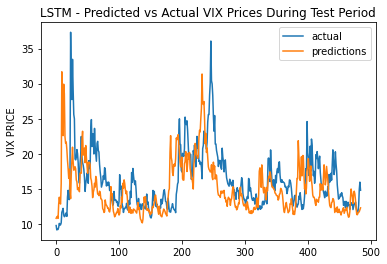

In [68]:
y_orig.plot(label="actual")
y_pred.plot(label="predictions")
plt.legend(loc="upper right")
plt.ylabel('VIX PRICE')
plt.title('LSTM - Predicted vs Actual VIX Prices During Test Period')

In [69]:
# predictor.delete_endpoint()